In [1]:
!pip install mxnet
!pip install gluonnlp
!pip install pandas tqdm
!pip install sentencepiece
!pip install transformers
!pip install torch
#import gluonnlp as np 해결

!pip install numpy==1.23.1

In [2]:
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

  Cloning https://github.com/SKTBrain/KoBERT.git to /tmp/pip-install-6b81g08v/kobert-tokenizer_11fbfa5001c24d0aa6bab2ec658a698a
  Running command git clone --filter=blob:none --quiet https://github.com/SKTBrain/KoBERT.git /tmp/pip-install-6b81g08v/kobert-tokenizer_11fbfa5001c24d0aa6bab2ec658a698a
  Resolved https://github.com/SKTBrain/KoBERT.git to commit 5c46b1c68e4755b54879431bd302db621f4d2f47
  Preparing metadata (setup.py) ... done
  Created wheel for kobert_tokenizer: filename=kobert_tokenizer-0.1-py3-none-any.whl size=4632 sha256=16514a61d5b0eca2b24da312901651b598372e30c342ba99682bcc421b7efbd3
  Stored in directory: /tmp/pip-ephem-wheel-cache-g06_gid0/wheels/e9/1a/3f/a864970e8a169c176befa3c4a1e07aa612f69195907a4045fe
Successfully built kobert_tokenizer


In [3]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import gluonnlp as nlp
import numpy as np
from tqdm import tqdm, tqdm_notebook

In [4]:
#KoBERT
from kobert_tokenizer import KoBERTTokenizer
from transformers import BertModel

from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup

In [5]:
# ★ tokenizer, model 정의
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
bertmodel = BertModel.from_pretrained('skt/kobert-base-v1', return_dict=False)
vocab = nlp.vocab.BERTVocab.from_sentencepiece(tokenizer.vocab_file, padding_token='[PAD]')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/371k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/535 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/369M [00:00<?, ?B/s]

In [6]:
#GPU 사용 시
device = torch.device("cuda:0")

In [8]:
# GPU 모델 확인
import os

n_devices = torch.cuda.device_count()
print(n_devices)

for i in range(n_devices):
    print(torch.cuda.get_device_name(i))

1
Tesla T4


In [9]:
# 구글 드라이브 마운트

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
import pandas as pd

In [32]:
data = pd.read_csv('/content/drive/MyDrive/capstone_dataset/감정대화말뭉치.csv', encoding='cp949')

<ipython-input-32-00b3e9ec1998>:1: DtypeWarning: Columns (0,3,5,7,9,11,14) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('/content/drive/MyDrive/capstone_dataset/감정대화말뭉치.csv', encoding='cp949')


In [33]:

# 5개의 감정 class → 숫자
data = data[~data['상황'].isin(["공포", "혐오"])]  # 공포와 혐오 제거

data.loc[(data['상황'] == "놀람"), '상황'] = 0  #놀람
data.loc[(data['상황'] == "분노"), '상황'] = 1  #분노
data.loc[(data['상황'] == "슬픔"), '상황'] = 2  #슬픔
data.loc[(data['상황'] == "중립"), '상황'] = 3  #중립
data.loc[(data['상황'] == "행복"), '상황'] = 4  #행복
data.loc[(data['상황'] == "당황"), '상황'] = 5  #당황
data.loc[(data['상황'] == "불안"), '상황'] = 6  #불안
data.loc[(data['상황'] == "상처"), '상황'] = 7  #상처


data_list = []
for ques, label in zip(data['발화문'], data['상황'])  :
    data = []
    data.append(ques)
    data.append(str(label))

    data_list.append(data)

# 결과 출력
print(data)
print(data_list[:10])

['유재석 오라버니 해피투게더 봤어요', '4']
[['헐! 나 이벤트에 당첨 됐어.', '4'], ['내가 좋아하는 인플루언서가 이벤트를 하더라고. 그래서 그냥 신청 한번 해봤지.', '4'], ['한 명 뽑는 거였는데, 그게 바로 내가 된 거야.', '4'], ['당연히 마음에 드는 선물이니깐, 이벤트에 내가 신청 한번 해본 거지. 비싼 거야. 그래서 못 산 향수야.', '4'], ['에피타이저 정말 좋아해. 그 것도 괜찮은 생각인 것 같애.', '3'], ['난 부페 형식의 음식들도 정말 좋아해. 그 것도 좀 알려 줘.', '3'], ['응. 완전히 끝난 거야. 한 달 동안 주말에 쉬지도 못하고 일만 했거든.', '4'], ['신나는 음악 듣는 것도 좋고, 어디 여행 가고 싶고 이 것 저 것 다 해보고 싶어.', '4'], ['친구들도 내 연락 기다리고 있을 텐데 내가 까먹고 있었네?', '4'], ['그래. 일단은 친구들부터 만나서 여행 계획에 대해서 얘기 좀 해봐야 되겠어.', '4']]


In [39]:
class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer,vocab, max_len,
                 pad, pair):

        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len,vocab=vocab, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))


    def __len__(self):
        return (len(self.labels))


In [40]:
# Setting parameters 필수
max_len = 64
batch_size = 64
warmup_ratio = 0.1
num_epochs = 10
max_grad_norm = 1
log_interval = 200
learning_rate =  5e-5

In [41]:
#train & test 데이터로 나누기
from sklearn.model_selection import train_test_split

dataset_train, dataset_test = train_test_split(data_list, test_size=0.2, shuffle=True, random_state=34)

In [42]:
#토큰화
tok=tokenizer.tokenize
data_train = BERTDataset(dataset_train, 0, 1, tok, vocab, max_len, True, False)
data_test = BERTDataset(dataset_test,0, 1, tok, vocab,  max_len, True, False)

train_dataloader = torch.utils.data.DataLoader(data_train, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(data_test, batch_size=batch_size, num_workers=5)

In [43]:
class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=8,   ##클래스 수 조정##
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate

        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)

    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)

        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device),return_dict=False)
        if self.dr_rate:
            out = self.dropout(pooler)
        return self.classifier(out)

In [44]:
#BERT 모델 불러오기
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

#optimizer와 schedule 설정
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss() # 다중분류를 위한 대표적인 loss func

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

#정확도 측정을 위한 함수 정의
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

train_dataloader

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [45]:
train_history=[]
test_history=[]
loss_history=[]
for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)

        #print(label.shape,out.shape)
        loss = loss_fn(out, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        scheduler.step()  # Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
            train_history.append(train_acc / (batch_id+1))
            loss_history.append(loss.data.cpu().numpy())
    print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
    #train_history.append(train_acc / (batch_id+1))

    model.eval()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        test_acc += calc_accuracy(out, label)
    print("epoch {} test acc {}".format(e+1, test_acc / (batch_id+1)))
    test_history.append(test_acc / (batch_id+1))

<ipython-input-45-225f425166d4>:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(train_dataloader)):


  0%|          | 0/1188 [00:00<?, ?it/s]

epoch 1 batch id 1 loss 2.1496667861938477 train acc 0.109375
epoch 1 batch id 201 loss 1.675445318222046 train acc 0.25225435323383083
epoch 1 batch id 401 loss 1.1373409032821655 train acc 0.3595308603491272
epoch 1 batch id 601 loss 1.2066349983215332 train acc 0.42291493344425957
epoch 1 batch id 801 loss 0.8075372576713562 train acc 0.4671894506866417
epoch 1 batch id 1001 loss 1.1066498756408691 train acc 0.497002997002997
epoch 1 train acc 0.5152245838009727


<ipython-input-45-225f425166d4>:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm_notebook(test_dataloader)):


  0%|          | 0/297 [00:00<?, ?it/s]

epoch 1 test acc 0.6346217860422406


  0%|          | 0/1188 [00:00<?, ?it/s]

epoch 2 batch id 1 loss 1.0692577362060547 train acc 0.640625
epoch 2 batch id 201 loss 1.034397840499878 train acc 0.6183924129353234
epoch 2 batch id 401 loss 0.8040671944618225 train acc 0.6254286159600998
epoch 2 batch id 601 loss 1.042026162147522 train acc 0.6313955906821963
epoch 2 batch id 801 loss 0.7435646057128906 train acc 0.6375234082397003
epoch 2 batch id 1001 loss 0.8743278384208679 train acc 0.643981018981019
epoch 2 train acc 0.6491004762127448


  0%|          | 0/297 [00:00<?, ?it/s]

epoch 2 test acc 0.643801652892562


  0%|          | 0/1188 [00:00<?, ?it/s]

epoch 3 batch id 1 loss 1.0005638599395752 train acc 0.671875
epoch 3 batch id 201 loss 0.8547797799110413 train acc 0.6784048507462687
epoch 3 batch id 401 loss 0.5794661641120911 train acc 0.68446072319202
epoch 3 batch id 601 loss 0.9819573163986206 train acc 0.6880979617304492
epoch 3 batch id 801 loss 0.6030606031417847 train acc 0.6936641697877652
epoch 3 batch id 1001 loss 0.891407310962677 train acc 0.7005026223776224
epoch 3 train acc 0.7054071774847238


  0%|          | 0/297 [00:00<?, ?it/s]

epoch 3 test acc 0.6450556703397612


  0%|          | 0/1188 [00:00<?, ?it/s]

epoch 4 batch id 1 loss 0.9071736931800842 train acc 0.640625
epoch 4 batch id 201 loss 0.7763793468475342 train acc 0.7352300995024875
epoch 4 batch id 401 loss 0.4780046343803406 train acc 0.737998753117207
epoch 4 batch id 601 loss 0.8203656673431396 train acc 0.7412385607321131
epoch 4 batch id 801 loss 0.5497869253158569 train acc 0.7467033395755306
epoch 4 batch id 1001 loss 0.6275613903999329 train acc 0.7523882367632367
epoch 4 train acc 0.757819319740616


  0%|          | 0/297 [00:00<?, ?it/s]

epoch 4 test acc 0.6467391720232629


  0%|          | 0/1188 [00:00<?, ?it/s]

epoch 5 batch id 1 loss 0.8576949834823608 train acc 0.75
epoch 5 batch id 201 loss 0.6133813858032227 train acc 0.7757307213930348
epoch 5 batch id 401 loss 0.4966185688972473 train acc 0.7839385910224439
epoch 5 batch id 601 loss 0.6346673369407654 train acc 0.7891014975041597
epoch 5 batch id 801 loss 0.5069248080253601 train acc 0.7952169163545568
epoch 5 batch id 1001 loss 0.4534452259540558 train acc 0.8002622377622378
epoch 5 train acc 0.8051035041775783


  0%|          | 0/297 [00:00<?, ?it/s]

epoch 5 test acc 0.6414782292623201


  0%|          | 0/1188 [00:00<?, ?it/s]

epoch 6 batch id 1 loss 0.6992010474205017 train acc 0.8125
epoch 6 batch id 201 loss 0.5044594407081604 train acc 0.8225279850746269
epoch 6 batch id 401 loss 0.3090309500694275 train acc 0.8275015586034913
epoch 6 batch id 601 loss 0.5808011293411255 train acc 0.8340006239600666
epoch 6 batch id 801 loss 0.40475326776504517 train acc 0.8390683520599251
epoch 6 batch id 1001 loss 0.33552801609039307 train acc 0.8435626873126874
epoch 6 train acc 0.8480376683501684


  0%|          | 0/297 [00:00<?, ?it/s]

epoch 6 test acc 0.6429599020508112


  0%|          | 0/1188 [00:00<?, ?it/s]

epoch 7 batch id 1 loss 0.581328809261322 train acc 0.78125
epoch 7 batch id 201 loss 0.3421737253665924 train acc 0.8603855721393034
epoch 7 batch id 401 loss 0.22952879965305328 train acc 0.8677914588528678
epoch 7 batch id 601 loss 0.5292252898216248 train acc 0.8719581946755408
epoch 7 batch id 801 loss 0.23628248274326324 train acc 0.8754681647940075
epoch 7 batch id 1001 loss 0.2601470947265625 train acc 0.8795891608391608
epoch 7 train acc 0.8826366481169723


  0%|          | 0/297 [00:00<?, ?it/s]

epoch 7 test acc 0.6417326675849404


  0%|          | 0/1188 [00:00<?, ?it/s]

epoch 8 batch id 1 loss 0.4155665934085846 train acc 0.90625
epoch 8 batch id 201 loss 0.2576470375061035 train acc 0.8907804726368159
epoch 8 batch id 401 loss 0.11678992956876755 train acc 0.8964307980049875
epoch 8 batch id 601 loss 0.3775830566883087 train acc 0.8997244176372712
epoch 8 batch id 801 loss 0.18559230864048004 train acc 0.9028948189762797
epoch 8 batch id 1001 loss 0.2629515826702118 train acc 0.9055475774225774
epoch 8 train acc 0.9074337121212122


  0%|          | 0/297 [00:00<?, ?it/s]

epoch 8 test acc 0.6422845883073156


  0%|          | 0/1188 [00:00<?, ?it/s]

epoch 9 batch id 1 loss 0.4908188581466675 train acc 0.875
epoch 9 batch id 201 loss 0.17175084352493286 train acc 0.9123134328358209
epoch 9 batch id 401 loss 0.07724776864051819 train acc 0.9154457605985037
epoch 9 batch id 601 loss 0.39300447702407837 train acc 0.918053244592346
epoch 9 batch id 801 loss 0.10249119997024536 train acc 0.9213483146067416
epoch 9 batch id 1001 loss 0.1622915267944336 train acc 0.9236700799200799
epoch 9 train acc 0.925044718013468


  0%|          | 0/297 [00:00<?, ?it/s]

epoch 9 test acc 0.6484752831343741


  0%|          | 0/1188 [00:00<?, ?it/s]

epoch 10 batch id 1 loss 0.46589547395706177 train acc 0.8125
epoch 10 batch id 201 loss 0.18752169609069824 train acc 0.9228078358208955
epoch 10 batch id 401 loss 0.07635577023029327 train acc 0.9266677057356608
epoch 10 batch id 601 loss 0.39176076650619507 train acc 0.9285825707154742
epoch 10 batch id 801 loss 0.07359196245670319 train acc 0.9299508426966292
epoch 10 batch id 1001 loss 0.12688642740249634 train acc 0.9315840409590409
epoch 10 train acc 0.9325547138047138


  0%|          | 0/297 [00:00<?, ?it/s]

epoch 10 test acc 0.6501233930211203


In [22]:
def new_softmax(a) :
    c = np.max(a) # 최댓값
    exp_a = np.exp(a-c) # 각각의 원소에 최댓값을 뺀 값에 exp를 취한다. (이를 통해 overflow 방지)
    sum_exp_a = np.sum(exp_a)
    y = (exp_a / sum_exp_a) * 100
    return np.round(y, 3)

In [46]:
## 학습 모델 저장
PATH = '/content/drive/MyDrive/capstone_dataset/model' # google 드라이브 연동 해야함. 관련코드는 뺐음
torch.save(model, PATH + 'KoBERT_담화.pt')  # 전체 모델 저장
torch.save(model.state_dict(), PATH + 'model_state_dict.pt')  # 모델 객체의 state_dict 저장
torch.save({
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict()
}, PATH + 'all.tar')  # 여러 가지 값 저장, 학습 중 진행 상황 저장을 위해 epoch, loss 값 등 일반 scalar값 저장 가능

In [47]:
def predict(predict_sentence):

    data = [predict_sentence, '0']
    dataset_another = [data]

    another_test = BERTDataset(dataset_another, 0, 1, tok, vocab, max_len, True, False)
    test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=batch_size, num_workers=5)

    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)

        valid_length= valid_length
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)


        test_eval=[]
        for i in out:
            logits=i
            logits = logits.detach().cpu().numpy()

            if np.argmax(logits) == 0:
                test_eval.append("놀람이")
            elif np.argmax(logits) == 1:
                test_eval.append("분노가")
            elif np.argmax(logits) == 2:
                test_eval.append("슬픔이")
            elif np.argmax(logits) == 3:
                test_eval.append("중립이")
            elif np.argmax(logits) == 4:
                test_eval.append("행복이")
            elif np.argmax(logits) == 5:
                test_eval.append("당황이")
            elif np.argmax(logits) == 6:
                test_eval.append("불안이")
            elif np.argmax(logits) == 7:
                test_eval.append("상처가")

        print(">> 입력하신 내용에서 " + test_eval[0] + " 느껴집니다.")

In [48]:
# 질문에 0 입력 시 종료
end = 1
while end == 1 :
    sentence = input("하고싶은 말을 입력해주세요 : ")
    if sentence == "0" :
        break
    predict(sentence)
    print("\n")

하고싶은 말을 입력해주세요 : 나 오늘 슬펐어
>> 입력하신 내용에서 슬픔이 느껴집니다.


하고싶은 말을 입력해주세요 : 나 오늘 너무...
>> 입력하신 내용에서 슬픔이 느껴집니다.


하고싶은 말을 입력해주세요 : 하..
>> 입력하신 내용에서 슬픔이 느껴집니다.


하고싶은 말을 입력해주세요 : 어머!
>> 입력하신 내용에서 놀람이 느껴집니다.


하고싶은 말을 입력해주세요 : 헤헤헤헹
>> 입력하신 내용에서 놀람이 느껴집니다.


하고싶은 말을 입력해주세요 : 집가고싶어
>> 입력하신 내용에서 슬픔이 느껴집니다.


하고싶은 말을 입력해주세요 : 집가자
>> 입력하신 내용에서 중립이 느껴집니다.


하고싶은 말을 입력해주세요 : 지금 상황에서 어떻게 해야되지?
>> 입력하신 내용에서 상처가 느껴집니다.


하고싶은 말을 입력해주세요 : 불안해
>> 입력하신 내용에서 불안이 느껴집니다.


하고싶은 말을 입력해주세요 : 나 너무 당황스러워
>> 입력하신 내용에서 당황이 느껴집니다.




KeyboardInterrupt: Interrupted by user

In [49]:
# 모델 평가 지표

from sklearn.metrics import classification_report

y_true = []  # 실제 라벨
y_pred = []  # 모델의 예측값

# 테스트 데이터셋에 대한 예측
model.eval()
for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
    token_ids = token_ids.long().to(device)
    segment_ids = segment_ids.long().to(device)
    valid_length = valid_length
    label = label.long().to(device)

    out = model(token_ids, valid_length, segment_ids)
    pred = np.argmax(out.detach().cpu().numpy(), axis=1)

    y_true.extend(label.cpu().numpy())
    y_pred.extend(pred)

# 분류 결과 보고
print(classification_report(y_true, y_pred, target_names=["놀람", "분노", "슬픔", "행복", "중립", "상처", "불안", "당황"]))


              precision    recall  f1-score   support

          놀람       0.68      0.69      0.68      1569
          분노       0.66      0.64      0.65      3666
          슬픔       0.67      0.65      0.66      3565
          행복       0.66      0.64      0.65      1564
          중립       0.86      0.87      0.86      3239
          상처       0.49      0.53      0.51      1706
          불안       0.53      0.57      0.55      1929
          당황       0.49      0.46      0.47      1761

    accuracy                           0.65     18999
   macro avg       0.63      0.63      0.63     18999
weighted avg       0.65      0.65      0.65     18999



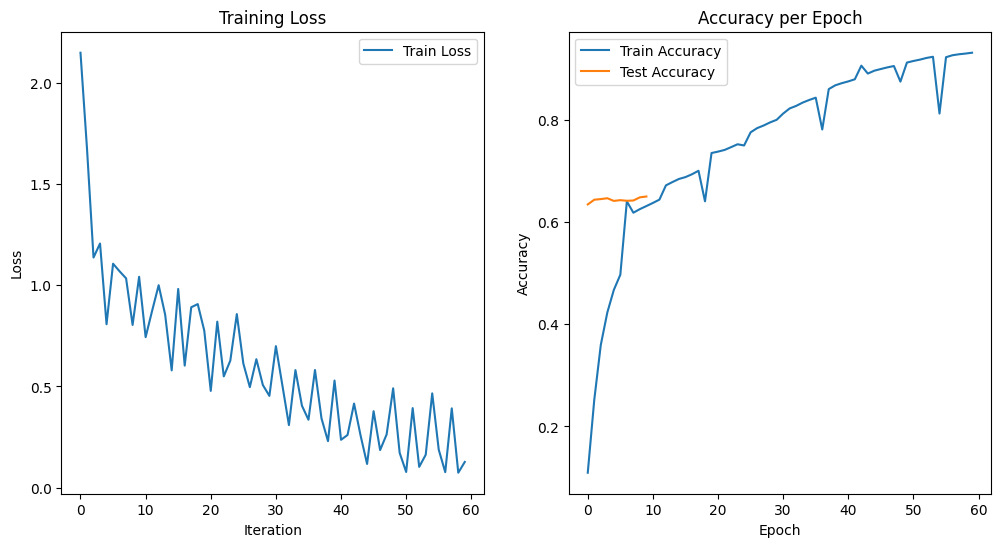

In [51]:
import matplotlib.pyplot as plt

# 손실 그래프
plt.figure(figsize=(12, 6))

# 손실율 그래프 그리기
plt.subplot(1, 2, 1)
plt.plot(loss_history, label="Train Loss")
plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

# 정확도 그래프 그리기
plt.subplot(1, 2, 2)
plt.plot(train_history, label="Train Accuracy")
plt.plot(test_history, label="Test Accuracy")
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# 그래프 출력
plt.show()

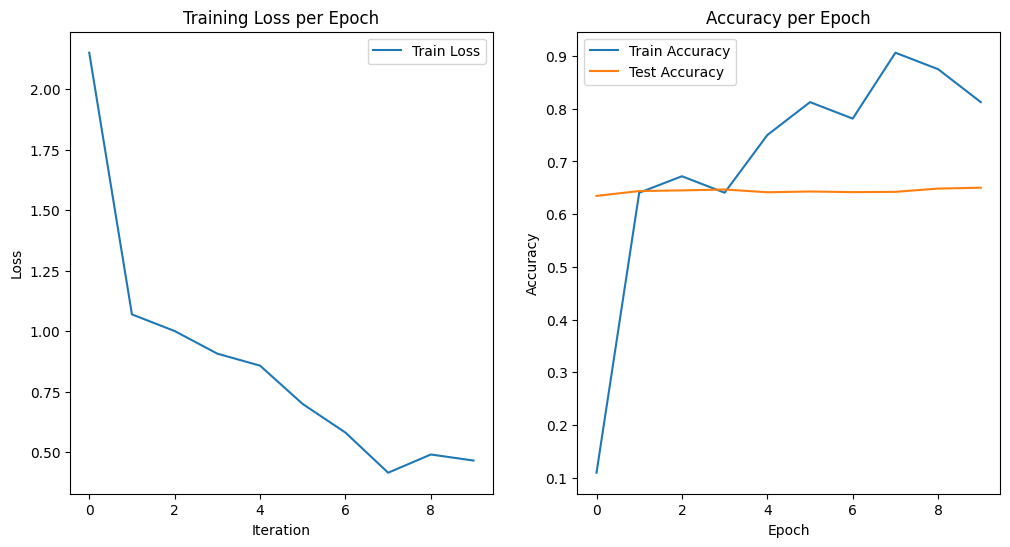

In [54]:
import matplotlib.pyplot as plt

# Train history와 Test history의 길이를 맞추기 위해 샘플링 (log_interval을 고려하여)
interval = len(train_history) // len(test_history)  # 몇 배수로 샘플링할지 결정

# train_history를 test_history와 길이를 맞추기 위해 간격에 맞춰 샘플링
train_history_sampled = train_history[::interval]
loss_history_sampled = loss_history[::interval]

# 손실율 그래프
plt.figure(figsize=(12, 6))

# 손실율 그래프 그리기
plt.subplot(1, 2, 1)
plt.plot(loss_history_sampled, label="Train Loss")
plt.title("Training Loss per Epoch")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

# 정확도 그래프 그리기
plt.subplot(1, 2, 2)
plt.plot(train_history_sampled, label="Train Accuracy")
plt.plot(test_history, label="Test Accuracy")
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

# 그래프 출력
plt.show()